In [1]:
import os
import copy
import time
import shelve
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
import matplotlib.pyplot as plt

In [2]:
def load_data(name):
    
    if name == 'mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    elif name == 'fashion_mnist':
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        print('Only mnist or fashion_mnist.')
        return False
    
    imageSize  = X_train.shape[1]*X_train.shape[2]
    numClasses = np.max(y_train)+1

    X_train = np.reshape(X_train.astype(float)/255.0, (-1, 784))
    X_test  = np.reshape(X_test.astype(float)/255.0, (-1, 784))
    
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=numClasses)
    y_test  = tf.keras.utils.to_categorical(y_test, num_classes=numClasses)

    X_val   = X_train[-10000:]
    y_val   = y_train[-10000:]
    X_train = X_train[:-10000]
    y_train = y_train[:-10000]

    print('Data Split: ')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
    print(f'X_test : {X_test.shape }, y_test : {y_test.shape }')
    print(f'X_val  : {X_val.shape  }, y_val  : {y_val.shape  }')

    data = {}
    data['X_train'] = X_train
    data['y_train'] = y_train
    data['X_val']   = X_val
    data['y_val']   = y_val
    data['X_test']  = X_test
    data['y_test']  = y_test
    
    data['imageSize'] = imageSize
    
    return data

In [3]:
class myOptimizer():
    
    def __init__(self, var):
           
        self.m = [np.zeros(np.shape(i)) for i in var]
        self.v = [np.zeros(np.shape(i)) for i in var]
        self.u = [np.zeros(np.shape(i)) for i in var]
            
        self.alpha   = 5e-4
        self.beta    = [0.9, 0.999, 0.999987]
        self.epsilon = [1e-8, 1e-6]
        
    def updateWeights(self, t, grads, var):
        
        for i in range(np.shape(var)[0]):
           
            self.m[i] = (self.beta[0]*self.m[i]) + ((1 - self.beta[0])*grads[i])
            self.v[i] = (self.beta[1]*self.v[i]) + ((1 - self.beta[1])*(grads[i]*grads[i]))
            self.u[i] = (self.beta[2]*self.u[i]) + ((1 - self.beta[2])*(grads[i]*grads[i]*grads[i]))

            mHat = self.m[i]/(1-self.beta[0]**t)
            vHat = self.v[i]/(1-self.beta[1]**t)
            uHat = self.u[i]/(1-self.beta[2]**t)
            
            # delta = self.alpha*mHat/((tf.sign(vHat)*tf.sqrt(tf.abs(vHat)))+(tf.sign(uHat)*tf.math.pow(tf.abs(uHat), 1/3)*self.epsilon[0])+self.epsilon[0])
            delta = self.alpha * mHat / (tf.sqrt(vHat)+(tf.sign(uHat)*tf.math.pow(tf.abs(uHat), 1/3)*self.epsilon[0] + self.epsilon[1]))
            var[i].assign(var[i] - delta)

In [4]:
class MLP(object):
    
    def __init__(self, name, size_input, size_hidden, size_output, learning_rate=0.01, weight_coeff=1,\
                  Reg=None, RegC=0, training=None, validation=None, accuracy=0, device=None):
       
        self.name          = name
        self.size_input    = size_input
        self.size_hidden   = size_hidden
        self.size_output   = size_output
        self.Reg           = Reg
        self.RegC          = RegC
        self.training      = training
        self.validation    = validation
        self.accuracy      = accuracy
        self.device        = device
        self.learning_rate = learning_rate
        self.weight_coeff  = weight_coeff     
        
        self.W1 = self.initWeights(self.size_input, self.size_hidden[0], self.weight_coeff)
        self.b1 = self.initWeights(1, self.size_hidden[0], self.weight_coeff)
        
        self.W2 = self.initWeights(self.size_hidden[0], self.size_hidden[1], self.weight_coeff)
        self.b2 = self.initWeights(1, self.size_hidden[1], self.weight_coeff)
        
        self.W3 = self.initWeights(self.size_hidden[1], self.size_hidden[2], self.weight_coeff)
        self.b3 = self.initWeights(1, self.size_hidden[2], self.weight_coeff)
        
        self.W4 = self.initWeights(self.size_hidden[2], self.size_output, self.weight_coeff)
        self.b4 = self.initWeights(1, self.size_output, self.weight_coeff)
        
        self.variables = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4]
        
        self.optimizer = myOptimizer(self.variables)
    
    def initWeights(self, rows, columns, multFactor=1):
        return tf.Variable(multFactor*tf.random.normal([rows, columns]))
    
    def forward(self, X):
        
        if self.device is not None:
            with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)
            
        return self.y
    
    def getRegLoss(self, X_train):
        
        if self.Reg=='L2':
            return (self.RegC/X_train.shape[0])*(tf.reduce_sum(tf.math.square(self.variables[0])) + 
                                                 tf.reduce_sum(tf.math.square(self.variables[2])) + 
                                                 tf.reduce_sum(tf.math.square(self.variables[4])) +
                                                 tf.reduce_sum(tf.math.square(self.variables[6])))
                
        elif self.Reg=='L1':
            return (self.RegC/X_train.shape[0])*tf.abs(tf.reduce_sum(self.variables[0]) + 
                                                       tf.reduce_sum(self.variables[2]) + 
                                                       tf.reduce_sum(self.variables[4]) +
                                                       tf.reduce_sum(self.variables[6]))
                
        elif self.Reg=='L1+L2':
            L2 =  (self.RegC/X_train.shape[0])*(tf.reduce_sum(tf.math.square(self.variables[0])) + 
                                                tf.reduce_sum(tf.math.square(self.variables[2])) + 
                                                tf.reduce_sum(tf.math.square(self.variables[4])) +
                                                tf.reduce_sum(tf.math.square(self.variables[6])))
                
            L1 = (self.RegC/X_train.shape[0])*tf.abs(tf.reduce_sum(self.variables[0]) + 
                                                     tf.reduce_sum(self.variables[2]) + 
                                                     tf.reduce_sum(self.variables[4]) +
                                                     tf.reduce_sum(self.variables[6]))
            return L1+L2
                
        else:
            return 0
        
    def loss(self, y_pred, y_true):
        
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        
        loss = tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
        return loss
    
    def backward(self, X_train, y_train, t):
                
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
            current_loss += self.getRegLoss(X_train)
         
        grads = tape.gradient(current_loss, self.variables)
        self.optimizer.updateWeights(t, grads, self.variables)  
           
        
    def compute_output(self, X):
        
        X_tf = tf.cast(X, dtype=tf.float32)

        w1Hat = tf.matmul(X_tf,  self.variables[0]) + self.variables[1]
        h1Hat = tf.nn.relu(w1Hat)
        
        w2Hat = tf.matmul(h1Hat, self.variables[2]) + self.variables[3]
        h2Hat = tf.nn.relu(w2Hat)
        
        w3Hat = tf.matmul(h2Hat, self.variables[4]) + self.variables[5]
        h3Hat = tf.nn.relu(w3Hat)
        
        w4Hat = tf.matmul(h3Hat, self.variables[6]) + self.variables[7]
        output = tf.nn.softmax(w4Hat)
        
        return output
        
    def getAccuracy(self, predictions, outputs):
        preds  = np.argmax(predictions, axis=1)
        y_true = np.argmax(outputs, axis=1)

        return (preds==y_true).mean()

In [5]:
def trainModel(model, data, NUM_EPOCHS=10, batchSize=50, seedVal=1234):
    
    X_train = data['X_train'] 
    y_train = data['y_train']
    X_val   = data['X_val']
    y_val   = data['y_val']

    training = np.zeros(shape=(NUM_EPOCHS, 3))
    validation = np.zeros(shape=(NUM_EPOCHS, 3))

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batchSize)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batchSize)

    print(f'\n\n**************** Training model: {model.name} with seed: {seedVal} ****************\n')
    time_start = time.time()
    for epoch in range(NUM_EPOCHS):
        train_loss = tf.zeros([1, 1], dtype=tf.float32)
        val_loss   = tf.zeros([1, 1], dtype=tf.float32)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed = epoch*(seedVal)).batch(batchSize)
        val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(25, seed = epoch*(seedVal)).batch(batchSize)

        t = 0
        for inputs, outputs in train_ds:
            t+=1   
            train_pred = model.forward(inputs)
            train_loss = train_loss + model.loss(train_pred, outputs)
            model.backward(inputs, outputs, t)
            train_acc = model.getAccuracy(train_pred, outputs)

        for inputs, outputs in val_ds:
            val_pred = model.forward(inputs)
            val_loss = val_loss + model.loss(val_pred, outputs)
            val_acc  = model.getAccuracy(val_pred, outputs)

        # train_loss = np.array(train_loss)
        # val_loss = np.array(val_loss)

        training[epoch] = [epoch+1, train_acc, np.sum(train_loss)/X_train.shape[0]]
        validation[epoch] = [epoch+1, val_acc, np.sum(train_loss)/X_train.shape[0]]

        print('# Epoch:={}/{}  - train loss:={:.4f} - val loss:={:.4f}, train acc:={:.2f} - val acc:={:.2f}'\
              .format(epoch+1, NUM_EPOCHS, np.sum(train_loss)/X_train.shape[0], np.sum(val_loss)/X_val.shape[0], train_acc, val_acc)) 

    time_taken = time.time()-time_start
    print(f'\nTotal time taken (in seconds): {time_taken: .2f}')
    print(f'\nFinished training model: {model.name}\n')
    model.training = training
    model.validation = validation

def testModel(model, data):
    
    X_test = data['X_test'] 
    y_test = data['y_test']
    
    preds = model.forward(X_test)
    
    pred = np.argmax(preds, axis=1)
    y_true= np.argmax(y_test, axis=1)

    model.accuracy = (pred==y_true).mean()*100
    
    print(f'**************** Testing ****************')
    print(f'{model.name} model accuracy = {model.accuracy:.2f}%')
    print(f'*****************************************')
    
def plotAccuracyAndLoss(model):
    
    training = model.training
    validation = model.validation
    fig, (ax1, ax2) = plt.subplots(1, 2)
    training[:, -1] = training[:, -1]/np.linalg.norm(training[:, -1]) 
    ax1.plot(training[:,0], training[:,1], 'g')
    ax1.plot(training[:,0], training[:,2], 'b')
    ax1.set_title('Training')
    ax1.legend(["Accuracy", "Loss"])

    validation[:, -1] = validation[:, -1]/np.linalg.norm(validation[:, -1]) 
    ax2.plot(validation[:,0], validation[:,1], 'g')
    ax2.plot(validation[:,0], validation[:,2], 'b')
    ax2.set_title('Validation')
    ax2.legend(["Accuracy", "Loss"])
    plt.show()

In [6]:
def main():
    
    for j in range(2):
        j=1
        
        if j==0:
            data = load_data('mnist')
            size_hidden = [512, 256, 128]
            learning_rate = 5e-4
            weight_coeff  = 0.1
            
        if j==1:
            print('fashion_mnist is running')
            data = load_data('fashion_mnist')
            size_hidden = [1024, 512, 256]
            learning_rate = 5e-4
            weight_coeff  = 0.1
         
        imageSize = data['imageSize']

        size_input  = imageSize
        size_output = 10

        allModels = {}
        # allModels['mlp_on_gpu_default'] = {}
        # allModels['mlp_on_gpu_RegL1']   = {}
        allModels['mlp_on_gpu_RegL2']   = {}  

        for model_name in allModels:
            model = allModels[model_name]

            cnt = -1

            numEpochs = 10
            batchSize = 50
            numTrials = 10

            seeds = random.sample(range(1000, 9999), numTrials)

                # loss     = np.zeros(shape=(numEpochs, 1))
            accuracy = np.zeros(shape=(numTrials, 1))

            for i in seeds:
                cnt += 1

                np.random.seed(i)
                tf.random.set_seed(i)

                print(f'Count: {cnt}, j=: {j}')
                if model_name == 'mlp_on_gpu_default':
                    model['name'] = MLP('mlp_on_gpu_default', size_input, size_hidden, size_output, learning_rate, weight_coeff,\
                                             device='gpu')

                elif model_name == 'mlp_on_gpu_RegL1':
                    model['name'] = MLP('mlp_on_gpu_RegL1', size_input, size_hidden, size_output, learning_rate, weight_coeff,\
                                            'L1', 1e-4, device='gpu')

                elif model_name == 'mlp_on_gpu_RegL2':
                    model['name'] = MLP('mlp_on_gpu_RegL2', size_input, size_hidden, size_output, learning_rate, weight_coeff,\
                                            'L2', 1e-4, device='gpu')

                else:
                    pass

                trainModel(model['name'], data, numEpochs, batchSize, i)
                testModel(model['name'], data)

                accuracy[cnt] = model['name'].accuracy

                plotAccuracyAndLoss(model['name'])

                allModels[model_name][i] = model['name']
                allModels[model_name]['Accuracy'] = [np.mean(accuracy), np.var(accuracy)]

        if j==0:
            mnist = allModels
        elif j==1:
            fashion_mnist = allModels
        else:
            pass
        
    

    return mnist, fashion_mnist

fashion_mnist is running
Data Split: 
X_train: (50000, 784), y_train: (50000, 10)
X_test : (10000, 784), y_test : (10000, 10)
X_val  : (10000, 784), y_val  : (10000, 10)
Count: 0, j=: 1


2022-03-05 14:10:48.429391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 14:10:48.433925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 14:10:48.434247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-05 14:10:48.435246: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags



**************** Training model: mlp_on_gpu_RegL2 with seed: 3151 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0103 - val loss:=0.0094, train acc:=0.70 - val acc:=0.86
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0085, train acc:=0.70 - val acc:=0.86
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0079, train acc:=0.84 - val acc:=0.90
# Epoch:=4/10  - train loss:=0.0052 - val loss:=0.0078, train acc:=0.90 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0075, train acc:=0.82 - val acc:=0.92
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0079, train acc:=0.86 - val acc:=0.88
# Epoch:=7/10  - train loss:=0.0039 - val loss:=0.0078, train acc:=0.86 - val acc:=0.88
# Epoch:=8/10  - train loss:=0.0035 - val loss:=0.0085, train acc:=0.80 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0033 - val loss:=0.0085, train acc:=0.80 - val acc:=0.90
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0079, train acc:=0.94 - val acc:=0.88

Total time taken (in seconds):  230.12

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

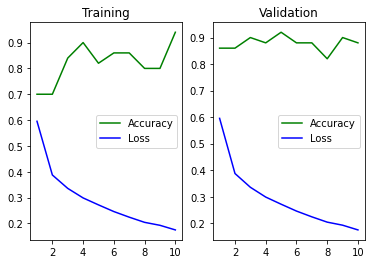

Count: 1, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 5559 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0102 - val loss:=0.0097, train acc:=0.80 - val acc:=0.88
# Epoch:=2/10  - train loss:=0.0066 - val loss:=0.0085, train acc:=0.74 - val acc:=0.88
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0080, train acc:=0.76 - val acc:=0.88
# Epoch:=4/10  - train loss:=0.0051 - val loss:=0.0082, train acc:=0.84 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0078, train acc:=0.82 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0074, train acc:=0.86 - val acc:=0.88
# Epoch:=7/10  - train loss:=0.0038 - val loss:=0.0079, train acc:=0.82 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0035 - val loss:=0.0089, train acc:=0.82 - val acc:=0.86
# Epoch:=9/10  - train loss:=0.0033 - val loss:=0.0092, train acc:=0.86 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0087, train acc:=0.88 - val acc:=0.88

Total time taken (in seconds):  220.86

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

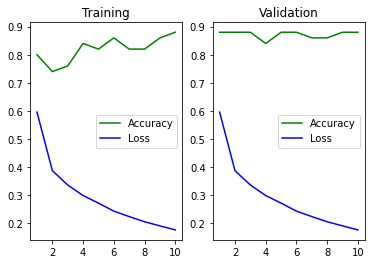

Count: 2, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 3710 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0104 - val loss:=0.0092, train acc:=0.74 - val acc:=0.88
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0092, train acc:=0.78 - val acc:=0.88
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0086, train acc:=0.82 - val acc:=0.90
# Epoch:=4/10  - train loss:=0.0052 - val loss:=0.0082, train acc:=0.88 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0075, train acc:=0.86 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0043 - val loss:=0.0079, train acc:=0.82 - val acc:=0.84
# Epoch:=7/10  - train loss:=0.0039 - val loss:=0.0077, train acc:=0.86 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0036 - val loss:=0.0075, train acc:=0.84 - val acc:=0.90
# Epoch:=9/10  - train loss:=0.0033 - val loss:=0.0084, train acc:=0.86 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0080, train acc:=0.84 - val acc:=0.82

Total time taken (in seconds):  225.22

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

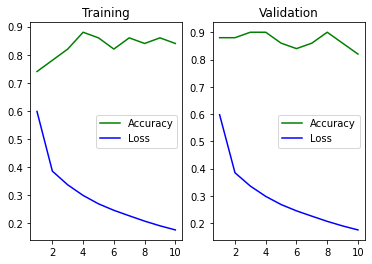

Count: 3, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 9476 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0104 - val loss:=0.0091, train acc:=0.70 - val acc:=0.88
# Epoch:=2/10  - train loss:=0.0068 - val loss:=0.0086, train acc:=0.72 - val acc:=0.92
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0085, train acc:=0.84 - val acc:=0.88
# Epoch:=4/10  - train loss:=0.0052 - val loss:=0.0076, train acc:=0.80 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0080, train acc:=0.78 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0043 - val loss:=0.0073, train acc:=0.88 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0039 - val loss:=0.0074, train acc:=0.82 - val acc:=0.88
# Epoch:=8/10  - train loss:=0.0036 - val loss:=0.0079, train acc:=0.88 - val acc:=0.86
# Epoch:=9/10  - train loss:=0.0033 - val loss:=0.0077, train acc:=0.90 - val acc:=0.86
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0085, train acc:=0.90 - val acc:=0.84

Total time taken (in seconds):  219.46

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

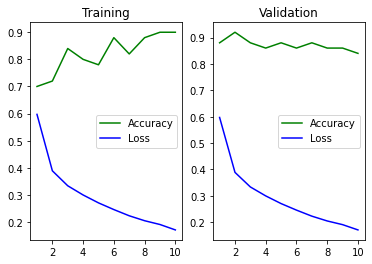

Count: 4, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 4009 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0104 - val loss:=0.0091, train acc:=0.68 - val acc:=0.84
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0082, train acc:=0.76 - val acc:=0.84
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0083, train acc:=0.76 - val acc:=0.86
# Epoch:=4/10  - train loss:=0.0052 - val loss:=0.0075, train acc:=0.84 - val acc:=0.90
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0074, train acc:=0.82 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0043 - val loss:=0.0077, train acc:=0.86 - val acc:=0.86
# Epoch:=7/10  - train loss:=0.0039 - val loss:=0.0081, train acc:=0.76 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0036 - val loss:=0.0079, train acc:=0.90 - val acc:=0.90
# Epoch:=9/10  - train loss:=0.0032 - val loss:=0.0075, train acc:=0.90 - val acc:=0.92
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0087, train acc:=0.88 - val acc:=0.88

Total time taken (in seconds):  221.81

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

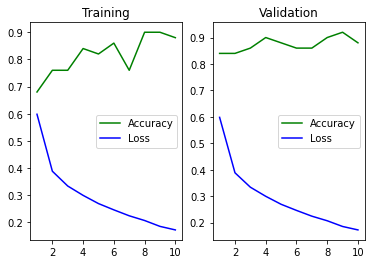

Count: 5, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 2526 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0107 - val loss:=0.0094, train acc:=0.70 - val acc:=0.88
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0087, train acc:=0.82 - val acc:=0.88
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0083, train acc:=0.84 - val acc:=0.86
# Epoch:=4/10  - train loss:=0.0051 - val loss:=0.0075, train acc:=0.86 - val acc:=0.92
# Epoch:=5/10  - train loss:=0.0046 - val loss:=0.0077, train acc:=0.86 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0084, train acc:=0.88 - val acc:=0.90
# Epoch:=7/10  - train loss:=0.0038 - val loss:=0.0079, train acc:=0.86 - val acc:=0.90
# Epoch:=8/10  - train loss:=0.0035 - val loss:=0.0077, train acc:=0.84 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0032 - val loss:=0.0085, train acc:=0.86 - val acc:=0.88
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0085, train acc:=0.88 - val acc:=0.90

Total time taken (in seconds):  228.06

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

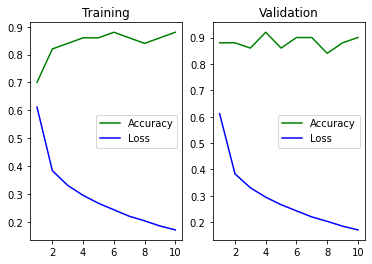

Count: 6, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 6769 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0105 - val loss:=0.0094, train acc:=0.78 - val acc:=0.84
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0082, train acc:=0.82 - val acc:=0.84
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0075, train acc:=0.80 - val acc:=0.86
# Epoch:=4/10  - train loss:=0.0052 - val loss:=0.0081, train acc:=0.84 - val acc:=0.86
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0075, train acc:=0.84 - val acc:=0.84
# Epoch:=6/10  - train loss:=0.0043 - val loss:=0.0076, train acc:=0.80 - val acc:=0.92
# Epoch:=7/10  - train loss:=0.0039 - val loss:=0.0080, train acc:=0.82 - val acc:=0.84
# Epoch:=8/10  - train loss:=0.0036 - val loss:=0.0081, train acc:=0.88 - val acc:=0.90
# Epoch:=9/10  - train loss:=0.0032 - val loss:=0.0080, train acc:=0.84 - val acc:=0.84
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0081, train acc:=0.92 - val acc:=0.86

Total time taken (in seconds):  228.90

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

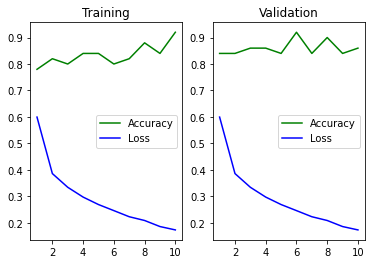

Count: 7, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 1002 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0108 - val loss:=0.0101, train acc:=0.64 - val acc:=0.86
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0091, train acc:=0.78 - val acc:=0.86
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0086, train acc:=0.78 - val acc:=0.88
# Epoch:=4/10  - train loss:=0.0051 - val loss:=0.0077, train acc:=0.86 - val acc:=0.94
# Epoch:=5/10  - train loss:=0.0047 - val loss:=0.0076, train acc:=0.88 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0073, train acc:=0.90 - val acc:=0.90
# Epoch:=7/10  - train loss:=0.0038 - val loss:=0.0075, train acc:=0.88 - val acc:=0.92
# Epoch:=8/10  - train loss:=0.0035 - val loss:=0.0083, train acc:=0.90 - val acc:=0.82
# Epoch:=9/10  - train loss:=0.0033 - val loss:=0.0081, train acc:=0.90 - val acc:=0.94
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0079, train acc:=0.92 - val acc:=0.90

Total time taken (in seconds):  228.50

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

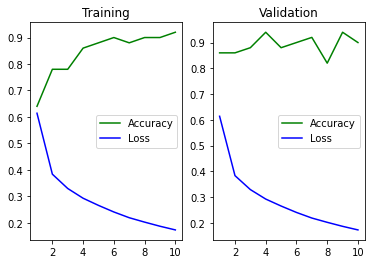

Count: 8, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 9353 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0105 - val loss:=0.0095, train acc:=0.74 - val acc:=0.84
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0083, train acc:=0.82 - val acc:=0.88
# Epoch:=3/10  - train loss:=0.0058 - val loss:=0.0078, train acc:=0.84 - val acc:=0.88
# Epoch:=4/10  - train loss:=0.0051 - val loss:=0.0073, train acc:=0.88 - val acc:=0.88
# Epoch:=5/10  - train loss:=0.0046 - val loss:=0.0079, train acc:=0.80 - val acc:=0.86
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0074, train acc:=0.90 - val acc:=0.90
# Epoch:=7/10  - train loss:=0.0039 - val loss:=0.0071, train acc:=0.90 - val acc:=0.86
# Epoch:=8/10  - train loss:=0.0035 - val loss:=0.0079, train acc:=0.82 - val acc:=0.84
# Epoch:=9/10  - train loss:=0.0033 - val loss:=0.0083, train acc:=0.80 - val acc:=0.90
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0080, train acc:=0.86 - val acc:=0.84

Total time taken (in seconds):  233.77

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

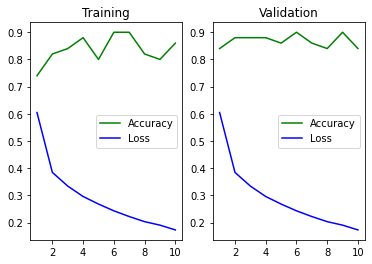

Count: 9, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 6147 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0107 - val loss:=0.0093, train acc:=0.76 - val acc:=0.94
# Epoch:=2/10  - train loss:=0.0067 - val loss:=0.0081, train acc:=0.84 - val acc:=0.90
# Epoch:=3/10  - train loss:=0.0057 - val loss:=0.0076, train acc:=0.82 - val acc:=0.90
# Epoch:=4/10  - train loss:=0.0051 - val loss:=0.0075, train acc:=0.82 - val acc:=0.84
# Epoch:=5/10  - train loss:=0.0046 - val loss:=0.0080, train acc:=0.86 - val acc:=0.88
# Epoch:=6/10  - train loss:=0.0042 - val loss:=0.0073, train acc:=0.80 - val acc:=0.88
# Epoch:=7/10  - train loss:=0.0038 - val loss:=0.0076, train acc:=0.74 - val acc:=0.90
# Epoch:=8/10  - train loss:=0.0035 - val loss:=0.0079, train acc:=0.84 - val acc:=0.88
# Epoch:=9/10  - train loss:=0.0032 - val loss:=0.0087, train acc:=0.82 - val acc:=0.90
# Epoch:=10/10  - train loss:=0.0030 - val loss:=0.0085, train acc:=0.88 - val acc:=0.90

Total time taken (in seconds):  225.44

Finished training model: mlp_on_gpu_RegL2

**************** Testing **********

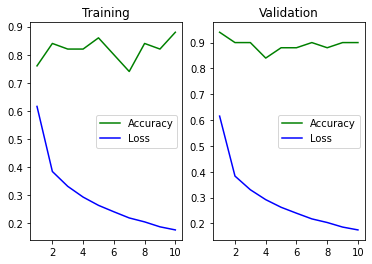

fashion_mnist is running
Data Split: 
X_train: (50000, 784), y_train: (50000, 10)
X_test : (10000, 784), y_test : (10000, 10)
X_val  : (10000, 784), y_val  : (10000, 10)
Count: 0, j=: 1


**************** Training model: mlp_on_gpu_RegL2 with seed: 2267 ****************



/home/skanda/Softwares/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Epoch:=1/10  - train loss:=0.0103 - val loss:=0.0091, train acc:=0.74 - val acc:=0.86


In [ ]:
if __name__ == "__main__":
    mnist = main()